In [1]:
import sys; sys.path.insert(0, '..') # So that we import the local copy of pyzx if you have installed from Github
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

from multiprocessing import Pool
import pyzx as zx
from pyzx import cnot_mapper, architecture # Note that this is the local pyzx package from this repository/fork, not the one installed through pip or other means.
from pyzx import circuit
from pyzx import *
from pyzx.parity_maps import CNOT_tracker, build_random_parity_map
from pyzx.linalg import Mat2
from pyzx.simplify import full_reduce

Load comb circuits

In [2]:
comb_circuit_folder = "../circuits/combs/"

circuit_properties = {"Qubits"    : 3,
                      "CNOTs"     : 2,
                      "Non-CNOTs" : 1}
path = os.path.join(comb_circuit_folder, 
                    str(circuit_properties["Qubits"])+"qubits", 
                    str(circuit_properties["CNOTs"])+"cnots", 
                    str(circuit_properties["Non-CNOTs"])+"non-cnots")
loaded_circuits = []
if os.path.exists(path):
    for file_name in os.listdir(path):
        loaded_circuits.append(circuit.Circuit.from_qasm_file(os.path.join(path, file_name)))
else:
    print("Directory Does Not Exist")

Test which circuits fail equality check when normal gaussian elimination is applied

In [3]:
gauss = False

if gauss:
    for circ in range(len(loaded_circuits)):
        # Decompose circuit
        comb_decomposition = CombDecomposition.from_circuit(loaded_circuits[circ].copy())
        comb = comb_decomposition.comb
        new_comb = CNOTComb(comb.qubits, comb.holes, comb.new_to_old_qubit_mappings)
        comb.matrix.gauss(full_reduce=True, x=new_comb)
        comb_decomposition.comb = new_comb
        new_circuit = CombDecomposition.to_circuit(comb_decomposition)
        print("{} : {}".format(circ, new_circuit.verify_equality(loaded_circuits[circ])))   
else:
    for circ in range(len(loaded_circuits)):
        # Decompose circuit
        comb_decomposition = CombDecomposition.from_circuit(loaded_circuits[circ].copy())
        comb = comb_decomposition.comb
        pre_arch = architecture.create_architecture(architecture.FULLY_CONNNECTED, n_qubits=loaded_circuits[circ].qubits)
        new_comb = CNOTComb(comb.qubits, comb.holes, comb.new_to_old_qubit_mappings)
        #comb.matrix.gauss(full_reduce=True, x=new_comb)
        cnot_mapper.gauss(cnot_mapper.ROWCOL_MODE,
                          comb.matrix,
                          CombArchitecture(pre_arch, comb),
                          circuit = new_comb
                         )
        comb_decomposition.comb = new_comb
        new_circuit = CombDecomposition.to_circuit(comb_decomposition)
        print("{} : {}".format(circ, new_circuit.verify_equality(loaded_circuits[circ])))   
    

{0: {1: 1, 2: 1}, 1: {0: 1, 2: 1}, 2: {0: 1, 1: 1}}
{0: {1: 1, 2: 1}, 1: {0: 1, 2: 1}, 2: {0: 1, 1: 1}, 3: {}}
{0: {1: 1, 2: 1, 3: 1}, 1: {0: 1, 2: 1, 3: 1}, 2: {0: 1, 1: 1}, 3: {0: 1, 1: 1}}
Row not correctly reduced in previous step!
[ 1.0  0.0  0.0  0.0 ]
[ 0.0  1.0  0.0  0.0 ]
[ 0.0  0.0  1.0  0.0 ]
[ 0.0  0.0  0.0  1.0 ]
Any key to continue.


Exception: Terminals not in the subgraph.[1][2, 3]

In [ ]:
circ = 0

comb_decomposition = CombDecomposition.from_circuit(loaded_circuits[circ].copy())
comb = comb_decomposition.comb
pre_arch = architecture.create_architecture(architecture.FULLY_CONNNECTED, n_qubits=loaded_circuits[circ].qubits)
#pre_arch.visualize("Pre")
#CombArchitecture(pre_arch, comb).visualize("Post")
new_comb = CNOTComb(comb.qubits, comb.holes, comb.new_to_old_qubit_mappings)
'''
cnot_mapper.gauss(cnot_mapper.ROWCOL_MODE,
                  comb.matrix,
                  CombArchitecture(pre_arch, comb),
                  circuit = new_comb
                 )
'''
m = np.array([
    [0, 1, 1, 1],
    [1, 0, 1, 1],
    [1, 1, 0, 0],
    [1, 1, 0, 0],
])
cnot_mapper.gauss(cnot_mapper.ROWCOL_MODE,
                  comb.matrix,
                  Architecture(name="Temp", coupling_matrix=m),
                  circuit = new_comb
                 )
comb_decomposition.comb = new_comb
new_circuit = CombDecomposition.to_circuit(comb_decomposition)
print("{} : {}".format(circ, new_circuit.verify_equality(loaded_circuits[circ])))   

In [4]:
from ipywidgets import widgets
from IPython.display import display, Markdown

def plotter(circ):
    # Decompose circuit
    display(zx.draw(loaded_circuits[circ]))
    comb_decomposition = CombDecomposition.from_circuit(loaded_circuits[circ].copy())
    comb = comb_decomposition.comb
    new_comb = CNOTComb(comb.qubits, comb.holes, comb.new_to_old_qubit_mappings)
    #comb.matrix.gauss(full_reduce=True, x=new_comb)
    cnot_mapper.gauss(cnot_mapper.ROWCOL_MODE,
                      comb.matrix,
                      architecture.create_architecture(architecture.FULLY_CONNNECTED, n_qubits=(comb.matrix.cols()+len(comb.holes))),
                      circuit=new_comb
                     )
    display(zx.draw(comb))
    print(comb.gates)
    display(zx.draw(new_comb))
    print(new_comb.gates)
    comb_decomposition.comb = new_comb
    new_circuit = CombDecomposition.to_circuit(comb_decomposition)
    display(zx.draw(new_circuit))
    print(new_circuit.verify_equality(loaded_circuits[circ]))
    
w = widgets.interactive(plotter, circ=(0,len(loaded_circuits)-1))
slider = w.children[0]
slider.layout.width = "{!s}px".format(min(800,1000))
output = w.children[-1]
output.layout.height = "{!s}px".format(1200)
slider.value = 0
w

interactive(children=(IntSlider(value=0, description='circ', layout=Layout(width='800px'), max=99), Output(lay…

Manually step through a simple representation of the proposed optimization algorithm. We generate an ordered list of vertices we wish to remove, oneying causallity. We then remove the vertices in order only using the qubits that are available at that point, this will be done by applying the rowcol algorithm to a submatrix of the full parity matrix which has rows removed.

In [ ]:
def extract_sub_matrix(matrix, index_list):
    new_matrix = Mat2(np.zeros([matrix.rows(), len(index_list)], dtype=int))
    for row in range(new_matrix.rows()):
        for col in range(new_matrix.cols()):
            new_matrix.data[row][col] = matrix.data[row][index_list[col]]
    return new_matrix
def insert_sub_matrix(matrix, sub_matrix, index_list):
    for row in range(sub_matrix.rows()):
        for col in range(sub_matrix.cols()):
            matrix.data[row][index_list[col]] = sub_matrix.data[row][col]
    return matrix

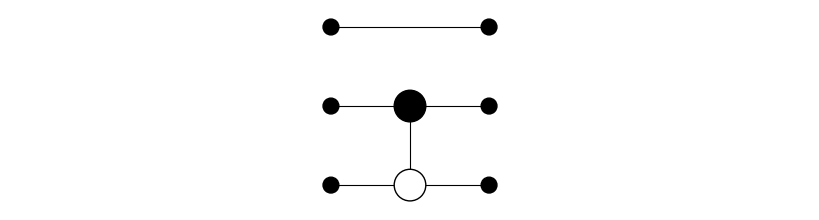

In [7]:


testMat = Mat2(np.array([
    [1, 0, 0, 0],
    [0, 1, 1, 1],
    [0, 0, 1, 1]
]))
tempCirc = CNOT_tracker(3)
#testMat.gauss(full_reduce=True, x=tempCirc)
cnot_mapper.gauss(cnot_mapper.ROWCOL_MODE,
                  testMat,
                  architecture.create_architecture(architecture.FULLY_CONNNECTED, n_qubits=(comb.matrix.cols()+len(comb.holes))),
                  circuit=tempCirc)
                     
zx.draw(tempCirc)